In [9]:
%pylab inline
import pandas as pd
import tensorflow as tf
import keras
from keras.datasets import mnist

batch_size = 12
epochs = 12


img_rows, img_cols = 28, 28

import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

In [3]:
class TFPCA(keras.Model):
    def __init__(self, input_dim=256*256*3, hidden_units=2):
        super(MyModel, self).__init__(name='tf_pca')
        self.input_dim = input_dim        
        self.hidden_units = hidden_units
        self.hidden = keras.layers.Dense(hidden_units, activation='linear')
        self.output = keras.layers.Dense(input_dim, activation='linear')
    def call(self, inputs):
        x = self.hidden(inputs)
        return self.output(x)
    def compute_output_shape(self, input_shape):
    # You need to override this function if you want to use the subclassed model
    # as part of a functional-style model.
    # Otherwise, this method is optional.
        shape = tf.TensorShape(input_shape).as_list()
        shape[-1] = input_shape
        return tf.TensorShape(shape)

config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
#config
    
class TFPCA(object):
    def __init__(self,
                 input_dim,
                 latent_dimensions=2,
                 learning_rate=0.001,                 
                 batch_size=50):
        self.learning_rate = learning_rate        
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dimensions = latent_dimensions

        self._build_network()
        self._create_loss_optimizer()

        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.global_variables())

    def _build_network(self):
        self.input = tf.placeholder(tf.float32, [None, self.input_dim])
        self.hidden = tf.layers.dense(activation=None, 
                                      inputs=self.input, 
                                      units=self.latent_dimensions)
        self.output = tf.layers.dense(activation=None, 
                                      inputs=self.hidden,
                                      units=self.input_dim)

    def _create_loss_optimizer(self):
        self.reconstruction_loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.input, 
                                                                                self.output))))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.reconstruction_loss)

    def fit_minibatch(self, batch):
        _, reconstruction_loss = self.session.run([self.optimizer, 
                                                   self.reconstruction_loss
                                                  ],
                                                  feed_dict={self.input: batch})
        return reconstruction_loss

    def reconstruct(self, x):
        return self.session.run([self.output], feed_dict={self.input: x})

    def decoder(self, z):
        return self.session.run([self.output], feed_dict={self.hidden: z})

    def encoder(self, x):
        return self.session.run([self.hidden], feed_dict={self.input: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step=epoch)

    def load_model(self, checkpoint_dir):
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=checkpoint_dir, latest_filename='checkpoint')
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, ckpt.model_checkpoint_path)

In [4]:
model = TFPCA(input_dim =img_cols*img_rows)

In [10]:
data = x_train
num_epoch = 50
num_sample = data.shape[0]
total_losses = []
checkpoint_dir = 'checkpoints'
for epoch in range(num_epoch):
    for iter in range(num_sample // batch_size):
        input_batch = data[iter*batch_size: min((iter+1)*batch_size, data.shape[0]),]
        total_loss = model.fit_minibatch(input_batch)
    total_losses.append(total_loss)

    if epoch % 5 == 0:
        print('[Epoch {}] Loss: {}'.format(
            epoch, total_loss))
        checkpoint_path = os.path.join(checkpoint_dir, 'model.ckpt')
        model.save_model(checkpoint_path, epoch)
        print ("model saved to {}".format(checkpoint_path))

print('Done!')

[Epoch 0] Loss: 0.23043814301490784
model saved to checkpoints/model.ckpt
[Epoch 5] Loss: 0.23005303740501404
model saved to checkpoints/model.ckpt
[Epoch 10] Loss: 0.22982831299304962
model saved to checkpoints/model.ckpt
[Epoch 15] Loss: 0.22974827885627747
model saved to checkpoints/model.ckpt
[Epoch 20] Loss: 0.22976532578468323
model saved to checkpoints/model.ckpt
[Epoch 25] Loss: 0.22971923649311066
model saved to checkpoints/model.ckpt
[Epoch 30] Loss: 0.22974631190299988
model saved to checkpoints/model.ckpt
[Epoch 35] Loss: 0.22978074848651886
model saved to checkpoints/model.ckpt
[Epoch 40] Loss: 0.22977188229560852
model saved to checkpoints/model.ckpt
[Epoch 45] Loss: 0.22973813116550446
model saved to checkpoints/model.ckpt
Done!


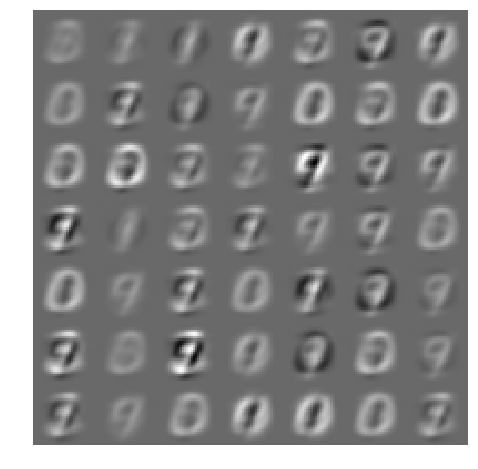

In [12]:
z = np.random.normal(size=[model.batch_size, model.latent_dimensions])
x_generated = model.decoder(z)[0]

w = h = 28
n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))

for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(w, h)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(I_generated, cmap='gray')


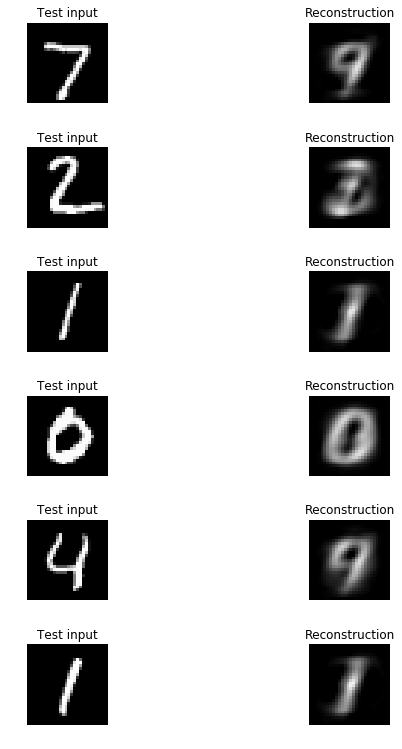

In [13]:
x_sample = x_test
y_sample = y_test
x_reconstruct = model.reconstruct(x_sample)

plt.figure(figsize=(8, 12))

for i in range(6):

    plt.subplot(7, 2, 2*i + 1)
    plt.axis('off')
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    #plt.colorbar()
    plt.subplot(7, 2, 2*i + 2)
    plt.axis('off')
    plt.imshow(x_reconstruct[0][i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    #plt.colorbar()
plt.tight_layout()


In [14]:
x_train_mean = x_train.mean(axis=0)
U, S, V = np.linalg.svd(x_train - x_train_mean, 
                        full_matrices=False)
z_pca = np.dot(x_train - x_train_mean, V.transpose())

reconstructed_pca = np.dot(z_pca[:,:2], V[:2,:]) + x_train_mean
err = (x_train-reconstructed_pca**2).mean(axis=None)

/home/saket/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


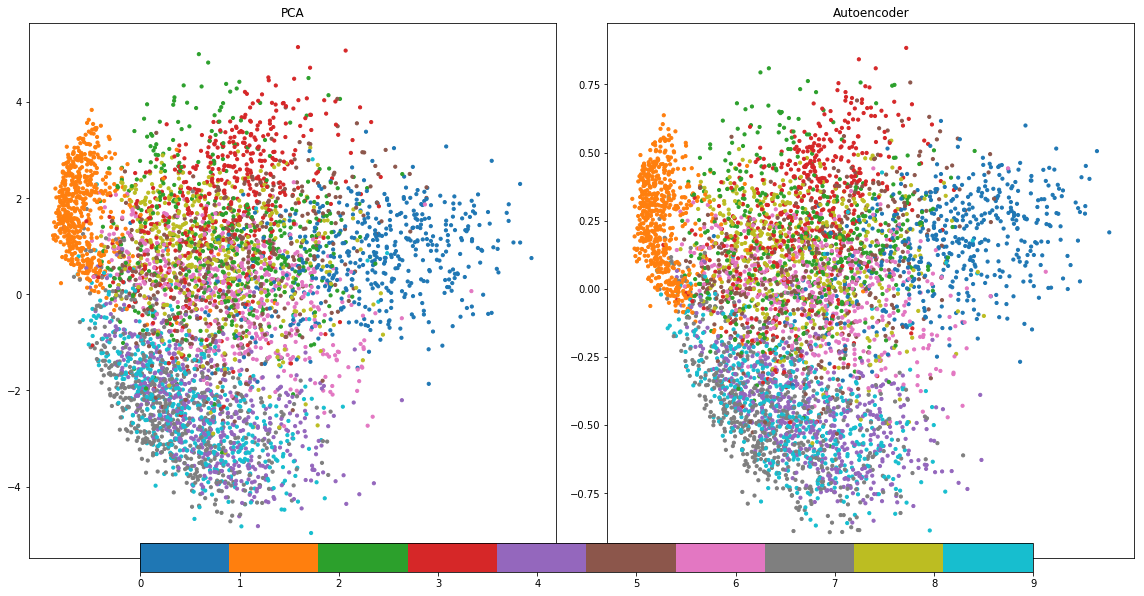

In [16]:
x_sample = x_train[:5000]
y_sample = y_train[:5000]
z_mu = model.encoder(x_sample)[0]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
ax1.set_title('PCA')
ax1.scatter(z_pca[:5000, 0], z_pca[:5000,1], c=y_train[:5000], s=10, cmap='tab10', alpha=1)

ax2 = plt.subplot(122)
s = ax2.scatter(z_mu[:, 0], -z_mu[:, 1], c=y_sample, s=10, cmap='tab10', alpha=1)
ax2.set_title('Autoencoder')
#ax.grid()
#ax.set_aspect('equal')

#fig.subplots_adjust(bottom=0.85)

#ax.set_aspect('equal')
#cbar_ax = fig.add_axes([0.15, -.1, 0.7, 0.05])

#cb = fig.colorbar(s, cax=cbar_ax, orientation='horizontal')
p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
#fig.co
fig.colorbar(s, cax=ax_cbar, orientation='horizontal')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
fig.tight_layout()